In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import netCDF4 as nc4

from scipy import interpolate

In [2]:
pmm = "netcdf_files/eORCA1.4.2_ModifStraits_domain_cfg.nc"

mm = nc4.Dataset(pmm)

glamt = mm.variables['glamt'][0] ; e1t = mm.variables['e1t'][0]
gphit = mm.variables['gphit'][0] ; e2t = mm.variables['e2t'][0] 
# U-V facets
e3t_1d = mm.variables['e3t_1d'][0] ; e3t_0 = mm.variables['e3t_0'][0] ; e3u_0 = mm.variables['e3u_0'][0]; e3v_0 = mm.variables['e3v_0'][0]
# partial cells
e3w_0 = mm.variables['e3w_0'][0] ; e3uw_0 = mm.variables['e3uw_0'][0] ; e3vw_0 = mm.variables['e3vw_0'][0]
e3w_1d = mm.variables['e3w_1d'][0]
#
totl = mm.variables['top_level'][0]  # 
botl = mm.variables['bottom_level'][0]  # goes from 0 to 74 (75 levels)
bath = mm.variables['bathy_meter'][0]   # goes from 0 to 74 (75 levels)
nK,nJ,nI = np.shape(e3w_0)

zdep = np.cumsum(e3t_1d) # 75 niveau w(k) pour cellule T(k-1)
mm.close()

---
### Read the protected cells

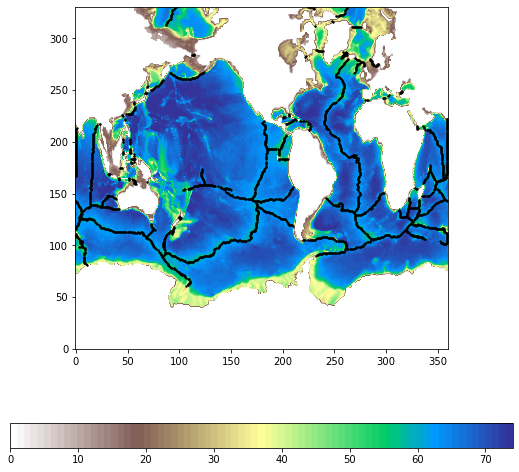

In [3]:
# https://mpl-point-clicker.readthedocs.io/en/latest/
palette = plt.get_cmap("terrain_r",75)
%matplotlib inline
fig, ax = plt.subplots(figsize=(9,9))
cf = plt.imshow(botl, cmap=palette)
fig.colorbar(cf,orientation="horizontal",shrink=0.8, location='bottom',aspect = 60, fraction=0.05,pad = 0.1)
ax.set_aspect(aspect='equal')

try : 
    with open('protected_cells_230113.npy', 'rb') as f:
        protected_nodes = np.load(f)
except :
    print("list not found")
plt.scatter(protected_nodes[:,0],protected_nodes[:,1],color="k", s=2)
# add zooming and middle click to pan
ax.invert_yaxis()
ax.patch.set_color('0.7')


plt.show()

---
# Volume penalisation


### 1) Penalisation of all the partial cells
Each levels are horizontally aligned. Evacuate the well-known associated with the terrain following coordinate. 
### 2) Vertical integration of the bathymetry

- For one column $(i,j)$ interpolate $b_{i,j}$ with the surrounding cells
  - if (i,j) is in the protected list, just skip it (as the partial cells alreay done)
  - coastlines cells unchanged below 10m
- Select vertically the vertically cells, find the intersections, plot it
- For each level, estimate (rectangular integration) the volume of water/land then save in the 3D array $\phi_t$

### 3) Add the implied changes in the netcdf
The total depth and vertical index of the last wet cells are modified.

In [4]:
""" 1) partial cells
"""
e3wp = np.copy(e3w_0)
for j in range(nJ):
    for i in range(nI):
        e3wp[:,j,i] = e3w_1d[:]    


In [35]:
""" 2.1) handle exceptions
"""
rpot = 0. * np.copy(e3t_0) # 3D array

mindex = np.zeros((nJ,nI))
with open('protected_cells_230113.npy', 'rb') as f:
    protected_nodes = np.load(f)

for node in protected_nodes:
    ii,jj = node
    kk0 = botl[jj,ii]
    rpot[:kk0   ,jj,ii] = 1.
    rpot[ kk0   ,jj,ii] = e3t_0[kk0,jj,ii]/e3t_1d[kk0]    
    if kk0 < nK-1 : rpot[ kk0+1:,jj,ii] = 0.
    mindex[jj,ii] = -1

In [36]:
# bathf # need a wet mean, coastlines or isolated island generate spurious slopes
bathf = 0.*np.copy(bath)
for i in range(1,nI-1):
    for j in range(nJ-1):
        #
        top_sum = totl[j+1,i] + totl[j+1,i+1] \
                + totl[j  ,i] + totl[j  ,i+1]
        if top_sum != 0 :
            # else coastland
            bathf[j,i] = ( bath[j+1,i] + bath[j+1,i+1]   \
                         + bath[j  ,i] + bath[j  ,i+1] ) / top_sum
        #

j = nJ-1 # Arctique # jj = 0 Antartique
#slice at cell 180(NEMO)->179(netcdf,python) on a U face (Canada)
for i in range(nI-1):
    c4 = (j,180-(i-179)) ; c3 = (j,180-(i+1-179)) #   | 4 | 3 |   
    c1 = (j,i          ) ; c2 = (j,i+1          ) #   --- + ---   
    #                                             #   | 1 | 2 | 
    top_sum = totl[c4] + totl[c3] \
            + totl[c1] + totl[c2]
    if top_sum != 0 :
        # else coastland
        bathf[j,i] = ( bath[c4] + bath[c3]   \
                     + bath[c1] + bath[c2] ) / top_sum

i = nI-1 # east indian ocean
for j in range(nJ-1):
    c4 = (j+1,i) ; c3 = (j+1,0)  
    c1 = (j  ,i) ; c2 = (j  ,0)  
    top_sum = totl[c4] + totl[c3] \
            + totl[c1] + totl[c2]
    if top_sum != 0 :
        # else coastland
        bathf[j,i] = ( bath[c4] + bath[c3]   \
                     + bath[c1] + bath[c2] ) / top_sum

i = 0 # west indian ocean
for j in range(nJ-1):
    c4 = (j+1,nI-1) ; c3 = (j+1,i)  
    c1 = (j  ,nI-1) ; c2 = (j  ,i) 
    top_sum = totl[c4] + totl[c3] \
            + totl[c1] + totl[c2]
    if top_sum != 0 :
        # else coastland
        bathf[j,i] = ( bath[c4] + bath[c3]   \
                     + bath[c1] + bath[c2] ) / top_sum

#! corners masked inland

In [37]:
""" 2.2) porosity estimation
"""
nx = 20 ; ny = 20
x = np.linspace(-0.5, 0.5, nx)
y = np.linspace(-0.5, 0.5, ny)

counter = 0
for ii in range(nI):
    for jj in range(1,nJ):
        counter+=1
        if counter%5E3 == 0 : print("counter : %d" % (counter))

        if mindex[jj,ii]==-1:
            continue # exception
        if totl[jj,ii] == 0 :
            continue # coastland
        #
        if ii == 0 :
            iim = nI-1 # east indian ocean
        else :
            iim = ii-1 # interior
        #
        """ Interpolate a smoothed bathymetry on the 2D domain +/- 0.5 """
        #lx, ly useless because linear interpolation
        # increasing ordered
        xx = np.array([-0.5, 0.5,-0.5,0.5])
        yy = np.array([-0.5,-0.5, 0.5,0.5])
        #                                                #    3------(4) 
        zz = np.array([bathf[jj-1,iim],                  #    |       |
                       bathf[jj-1,ii  ],                 #    |  (+)  |
                       bathf[jj  ,iim],                  #    |       |
                       bathf[jj  ,ii  ]])                #    1-------2         
        fz = interpolate.bisplrep(xx,yy,zz,kx=1,ky=1)                    
        """ Find the impacted cells """
        kkm = np.argmin(np.abs(zdep-np.min(zz)))
        if zdep[kkm]>np.min(zz) : kkm-=1

        kkp = np.argmin(np.abs(zdep-np.max(zz)))
        if zdep[kkm]<np.max(zz) and kkp <74 : kkp+=1
        
        rpot[:kkp,jj,ii] = 1. ; rpot[kkp:,jj,ii] = 0.
        """ Define the land indicator function at each level fland """
        for kk in range(kkm,kkp+1):
            # maximum or minimum element wise # fk wants to be under (k-1, deeper) but above (k, higher)
            fk = lambda x,y : np.maximum( zdep[kk-1], np.minimum( zdep[kk], interpolate.bisplev(x, y, fz) ))
            # >0 == land
            fland = lambda x,y : (zdep[kk]-fk(x,y))/(zdep[kk]-zdep[kk-1])
            r_land = np.sum(fland(x,y))/(nx*ny)

            rpot[kk,jj,ii] = 1 - r_land
print("finished")

counter : 5000
counter : 10000
counter : 15000
counter : 20000
counter : 25000
counter : 30000
counter : 35000
counter : 40000
counter : 45000
counter : 50000
counter : 55000
counter : 60000
counter : 65000
counter : 70000
counter : 75000
counter : 80000
counter : 85000
counter : 90000
counter : 95000
counter : 100000
counter : 105000
counter : 110000
counter : 115000
finished


In [ ]:
""" 3) Add changes to netcedf
"""

Ht = np.zeros((nJ,nI))     # future bathy_meter
lastk = np.zeros((nJ,nI))  # future bottom_levels

# niveau NEMO (donc 1->jpk), en python (0->jpk-1)
# si j'ai 3 éléments dans ma liste mbathy = 3 (NEMO 1,2,3), mbathy = 2 (python, 0,1,2)
# mbathy == nb_vertical_cells(rpot)

for i in range(nI):
    for j in range(nJ):
        Ht   [j,i] = np.sum(rpot[:,j,i]*e3t_1d[:])
        lastk[j,i] = np.min((74,np.sum(rpot[:,80,80]>0.) + 1)) # +1 for rn_abp


---
# Data for visualisation

In [38]:
with open('rpot.npy', 'wb') as f:
    np.save(f, rpot,allow_pickle=True)
print("saved")

saved
